In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

tf.random.set_seed(777)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Original Data Set

In [3]:
data = pd.read_csv('winequality-red.csv')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
data = data.sample(frac=1,random_state = 777)
data_ar = np.array(data)
x_data = data_ar[:,0:-1]
y_data = data_ar[:,[-1]]

print(x_data.shape)

print(y_data.shape)

(1599, 11)
(1599, 1)


# Y_data - quality

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

[5 6 4 7 3 8]
6


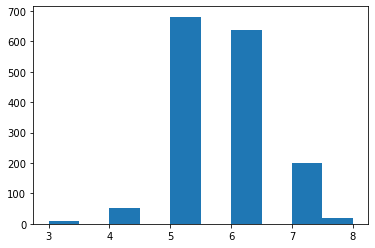

In [5]:
print(data['quality'].value_counts())
print()
Y_value = data['quality'].unique()
print(Y_value)

nb_classes = Y_value.shape[0]
print(nb_classes)

plt.hist(data['quality'])
plt.xticks([3,4,5,6,7,8])
plt.show()

In [6]:
print(y_data)


[[5.]
 [6.]
 [5.]
 ...
 [6.]
 [5.]
 [5.]]


# one_hot encoding

In [7]:
y_data_label=np.zeros((y_data.shape[0], 1))
for i in range(y_data.shape[0]):
    y_data_label[i][0] = y_data[i][0] - 3

#num = array_count_values(y_data_label)
print(y_data_label)
print(np.unique(y_data_label, return_counts = True))


[[2.]
 [3.]
 [2.]
 ...
 [3.]
 [2.]
 [2.]]
(array([0., 1., 2., 3., 4., 5.]), array([ 10,  53, 681, 638, 199,  18], dtype=int64))


In [8]:
# Y_label = 3, 4, 5, 6, 7, 8

# Convert y_data to one_hot
Y_one_hot = tf.keras.utils.to_categorical(y_data_label, nb_classes)
print("one_hot: \n", Y_one_hot)

one_hot: 
 [[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


# Train / Validation / Test  Data Set

In [9]:
X_train=x_data[:int(len(x_data)*0.6),:]
Y_train=Y_one_hot[:int(len(Y_one_hot)*0.6),:]

X_val=x_data[int(len(x_data)*0.6):int(len(x_data)*0.8),:]
Y_val=Y_one_hot[int(len(Y_one_hot)*0.6):int(len(Y_one_hot)*0.8),:]

X_test=x_data[int(len(x_data)*0.8):,:]
Y_test=Y_one_hot[int(len(Y_one_hot)*0.8):,:]

print(X_train.shape)
print(Y_train.shape)
print()
print(X_val.shape)
print(Y_val.shape)
print()
print(X_test.shape)
print(Y_test.shape)

(959, 11)
(959, 6)

(320, 11)
(320, 6)

(320, 11)
(320, 6)


# Scaler

In [10]:
# normalization

def MinMaxScaler_train(data):
    numerator = data - np.min(data,0)
    denominator = np.max(data,0) - np.min(data,0)
# 0으로 나누는 것을 방지
    return numerator / (denominator + 1e-7)

def MinMaxScaler_val_test(data, train_min, train_max):
    numerator = data - train_min
    denominator = train_max - train_min
# 0으로 나누는 것을 방지
    return numerator / (denominator + 1e-7)

trainx_norm = MinMaxScaler_train(X_train)

trainx_min = np.array(np.min(X_train,0))
trainx_max = np.array(np.max(X_train,0))

valx_norm = MinMaxScaler_val_test(X_val, trainx_min, trainx_max)
testx_norm = MinMaxScaler_val_test(X_test, trainx_min, trainx_max)

print(trainx_norm)

print(valx_norm)

print(testx_norm)

[[0.34821428 0.49999996 0.23999998 ... 0.45669288 0.44311375 0.13846154]
 [0.29464285 0.38016526 0.27999997 ... 0.37795273 0.1257485  0.15384615]
 [0.28571428 0.04958677 0.39999996 ... 0.42519682 0.22155687 0.41538461]
 ...
 [0.28571428 0.15702478 0.31999997 ... 0.52755901 0.13772454 0.64615384]
 [0.46428571 0.31404956 0.49999995 ... 0.33070864 0.25149699 0.06153846]
 [0.30357143 0.5454545  0.22999998 ... 0.49606295 0.13772454 0.44615384]]
[[0.27678571 0.39669418 0.25999997 ... 0.37007871 0.11377245 0.23076923]
 [0.16964286 0.64049581 0.04       ... 0.6220472  0.14970059 0.36923076]
 [0.47321428 0.15702478 0.46999995 ... 0.48818894 0.28143711 0.32307692]
 ...
 [0.0625     0.38016526 0.07999999 ... 0.59842515 0.18562873 0.27692307]
 [0.64285714 0.22314048 0.68999993 ... 0.28346454 0.16766466 0.36923076]
 [0.48214285 0.21487602 0.49999995 ... 0.37795273 0.19161675 0.49230768]]
[[0.60714285 0.34710741 0.70999993 ... 0.21259841 0.29940118 0.52307692]
 [0.21428571 0.52066111 0.01       ... 

In [11]:
# Standrad Scaler
#from sklearn.preprocessing import StandardScaler

#scaler=StandardScaler()

#scaler.fit(x_train_set)
#X_train_norm=scaler.transform(x_train_set)

#scaler.fit(x_test_set)
#X_test_norm=scaler.transform(x_test_set)

#print(X_train_norm)
#print()
#print(X_test_norm)

# Train/ Val / Test _y label별 개수

In [12]:
trainy_3_index = []
trainy_4_index = []
trainy_5_index = []
trainy_6_index = []
trainy_7_index = []
trainy_8_index = []

for i in range(len(Y_train)):
    if Y_train[i][0] == 1.0 :
        trainy_3_index.append(i)
    elif Y_train[i][1] == 1.0 :
        trainy_4_index.append(i)   
    elif Y_train[i][2] == 1.0 :
        trainy_5_index.append(i)
    elif Y_train[i][3] == 1.0 :
        trainy_6_index.append(i)
    elif Y_train[i][4] == 1.0 :
        trainy_7_index.append(i)
    elif Y_train[i][5] == 1.0 :
        trainy_8_index.append(i)

print("train_Y")
print("3: " ,len(trainy_3_index))
print("4: " ,len(trainy_4_index))
print("5: " ,len(trainy_5_index))
print("6: " ,len(trainy_6_index))
print("7: " ,len(trainy_7_index))
print("8: " ,len(trainy_8_index))


train_Y
3:  5
4:  29
5:  418
6:  384
7:  111
8:  12


In [13]:
valy_3_index = []
valy_4_index = []
valy_5_index = []
valy_6_index = []
valy_7_index = []
valy_8_index = []

for i in range(len(Y_val)):
    if Y_val[i][0] == 1.0 :
        valy_3_index.append(i)
    elif Y_val[i][1] == 1.0 :
        valy_4_index.append(i)   
    elif Y_val[i][2] == 1.0 :
        valy_5_index.append(i)
    elif Y_val[i][3] == 1.0 :
        valy_6_index.append(i)
    elif Y_val[i][4] == 1.0 :
        valy_7_index.append(i)
    elif Y_val[i][5] == 1.0 :
        valy_8_index.append(i)

print("val_Y")
print("3: " ,len(valy_3_index))
print("4: " ,len(valy_4_index))
print("5: " ,len(valy_5_index))
print("6: " ,len(valy_6_index))
print("7: " ,len(valy_7_index))
print("8: " ,len(valy_8_index))


val_Y
3:  4
4:  13
5:  135
6:  121
7:  44
8:  3


In [14]:
testy_3_index = []
testy_4_index = []
testy_5_index = []
testy_6_index = []
testy_7_index = []
testy_8_index = []

for i in range(len(Y_test)):
    if Y_test[i][0] == 1.0 :
        testy_3_index.append(i)
    elif Y_test[i][1] == 1.0 :
        testy_4_index.append(i)   
    elif Y_test[i][2] == 1.0 :
        testy_5_index.append(i)
    elif Y_test[i][3] == 1.0 :
        testy_6_index.append(i)
    elif Y_test[i][4] == 1.0 :
        testy_7_index.append(i)
    elif Y_test[i][5] == 1.0 :
        testy_8_index.append(i)

print("test_Y")
print("3: " ,len(testy_3_index))
print("4: " ,len(testy_4_index))
print("5: " ,len(testy_5_index))
print("6: " ,len(testy_6_index))
print("7: " ,len(testy_7_index))
print("8: " ,len(testy_8_index))


test_Y
3:  1
4:  11
5:  128
6:  133
7:  44
8:  3


# X data _ 4차원

In [15]:
X_train_4 = trainx_norm.reshape(trainx_norm.shape[0], trainx_norm.shape[1], 1, 1)
X_val_4 = valx_norm.reshape(valx_norm.shape[0], valx_norm.shape[1], 1, 1)
X_test_4 = testx_norm.reshape(testx_norm.shape[0], testx_norm.shape[1], 1, 1)
print(X_train_4.shape)
print(X_val_4.shape)
print(X_test_4.shape)

(959, 11, 1, 1)
(320, 11, 1, 1)
(320, 11, 1, 1)


# Model

In [16]:
# parameters
input_dim=(X_train_4.shape[1],X_train_4.shape[2],X_train_4.shape[3])
output_dim=Y_train.shape[1]

# hyper poarameters
learning_rate=0.01
training_epochs=500
batch_size=50
drop_rate=0.3

tf.model = tf.keras.Sequential()

tf.model.add(tf.keras.layers.Conv2D(filters=40, kernel_size=(2, 2), padding='same', input_shape=input_dim, activation='relu'))
tf.model.add(tf.keras.layers.Dropout(drop_rate))

tf.model.add(tf.keras.layers.Conv2D(filters=40, kernel_size=(2, 2), padding='same', activation='relu'))
tf.model.add(tf.keras.layers.Dropout(drop_rate))

#tf.model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
#tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=1))
#tf.model.add(tf.keras.layers.Dropout(drop_rate))

# fully connected
tf.model.add(tf.keras.layers.Flatten())
tf.model.add(tf.keras.layers.Dense(units=250, activation='relu'))
tf.model.add(tf.keras.layers.Dropout(drop_rate))
tf.model.add(tf.keras.layers.Dense(units=100, activation='relu'))
tf.model.add(tf.keras.layers.Dropout(drop_rate))
tf.model.add(tf.keras.layers.Dense(units=50, activation='relu'))
tf.model.add(tf.keras.layers.Dropout(drop_rate))
#tf.model.add(tf.keras.layers.Dense(units=12, kernel_initializer='glorot_normal', activation='relu'))
tf.model.add(tf.keras.layers.Dense(units=output_dim, activation='softmax'))

tf.model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

tf.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 1, 40)         200       
_________________________________________________________________
dropout (Dropout)            (None, 11, 1, 40)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 1, 40)         6440      
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 1, 40)         0         
_________________________________________________________________
flatten (Flatten)            (None, 440)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               110250    
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0

In [17]:
history = tf.model.fit(X_train_4, Y_train, epochs=training_epochs, validation_data=(X_val_4,Y_val))

Epoch 1/500
30/30 [==============================] - 1s 30ms/step - loss: 1.3988 - accuracy: 0.3997 - val_loss: 1.2428 - val_accuracy: 0.4219
Epoch 2/500
30/30 [==============================] - 0s 3ms/step - loss: 1.2178 - accuracy: 0.4150 - val_loss: 1.2347 - val_accuracy: 0.4219
Epoch 3/500
30/30 [==============================] - 0s 4ms/step - loss: 1.1360 - accuracy: 0.4332 - val_loss: 1.1900 - val_accuracy: 0.5469
Epoch 4/500
30/30 [==============================] - 0s 4ms/step - loss: 1.1265 - accuracy: 0.5484 - val_loss: 1.1477 - val_accuracy: 0.5188
Epoch 5/500
30/30 [==============================] - 0s 4ms/step - loss: 1.0964 - accuracy: 0.5347 - val_loss: 1.0679 - val_accuracy: 0.5750
Epoch 6/500
30/30 [==============================] - 0s 3ms/step - loss: 1.0438 - accuracy: 0.5876 - val_loss: 1.0633 - val_accuracy: 0.5625
Epoch 7/500
30/30 [==============================] - 0s 3ms/step - loss: 1.0424 - accuracy: 0.5474 - val_loss: 1.0509 - val_accuracy: 0.5750
Epoch 8/500


Epoch 59/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9671 - accuracy: 0.5757 - val_loss: 1.0067 - val_accuracy: 0.5562
Epoch 60/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9870 - accuracy: 0.5835 - val_loss: 1.0293 - val_accuracy: 0.5406
Epoch 61/500
30/30 [==============================] - 0s 4ms/step - loss: 1.0399 - accuracy: 0.5542 - val_loss: 1.0372 - val_accuracy: 0.5531
Epoch 62/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9828 - accuracy: 0.5966 - val_loss: 1.0318 - val_accuracy: 0.5813
Epoch 63/500
30/30 [==============================] - 0s 3ms/step - loss: 1.0033 - accuracy: 0.5472 - val_loss: 1.0259 - val_accuracy: 0.5688
Epoch 64/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9936 - accuracy: 0.5682 - val_loss: 1.0236 - val_accuracy: 0.5719
Epoch 65/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9856 - accuracy: 0.5744 - val_loss: 0.9988 - val_accuracy: 0.5875
Epoch 

30/30 [==============================] - 0s 4ms/step - loss: 0.9907 - accuracy: 0.5726 - val_loss: 1.0112 - val_accuracy: 0.5781
Epoch 117/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9628 - accuracy: 0.5906 - val_loss: 1.0126 - val_accuracy: 0.5875
Epoch 118/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9708 - accuracy: 0.5936 - val_loss: 1.0126 - val_accuracy: 0.5656
Epoch 119/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9681 - accuracy: 0.5945 - val_loss: 1.0198 - val_accuracy: 0.5625
Epoch 120/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9639 - accuracy: 0.5905 - val_loss: 0.9599 - val_accuracy: 0.5813
Epoch 121/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9469 - accuracy: 0.5829 - val_loss: 1.0044 - val_accuracy: 0.5625
Epoch 122/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9925 - accuracy: 0.5911 - val_loss: 0.9903 - val_accuracy: 0.5781
Epoch 123/500

30/30 [==============================] - 0s 3ms/step - loss: 1.0108 - accuracy: 0.5822 - val_loss: 1.0152 - val_accuracy: 0.5531
Epoch 174/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9517 - accuracy: 0.6055 - val_loss: 1.0275 - val_accuracy: 0.5562
Epoch 175/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9886 - accuracy: 0.5792 - val_loss: 1.0068 - val_accuracy: 0.5656
Epoch 176/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9461 - accuracy: 0.6170 - val_loss: 1.0001 - val_accuracy: 0.5719
Epoch 177/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9608 - accuracy: 0.5908 - val_loss: 1.0227 - val_accuracy: 0.5813
Epoch 178/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9549 - accuracy: 0.6000 - val_loss: 0.9985 - val_accuracy: 0.6062
Epoch 179/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9492 - accuracy: 0.5793 - val_loss: 1.0166 - val_accuracy: 0.5562
Epoch 180/500

30/30 [==============================] - 0s 3ms/step - loss: 0.9835 - accuracy: 0.5834 - val_loss: 1.0141 - val_accuracy: 0.5719
Epoch 231/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9540 - accuracy: 0.6036 - val_loss: 1.0382 - val_accuracy: 0.5625
Epoch 232/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9846 - accuracy: 0.5527 - val_loss: 1.0155 - val_accuracy: 0.5625
Epoch 233/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9453 - accuracy: 0.5820 - val_loss: 1.0077 - val_accuracy: 0.5688
Epoch 234/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9615 - accuracy: 0.5854 - val_loss: 1.0118 - val_accuracy: 0.5719
Epoch 235/500
30/30 [==============================] - 0s 3ms/step - loss: 1.0163 - accuracy: 0.5565 - val_loss: 1.0070 - val_accuracy: 0.5594
Epoch 236/500
30/30 [==============================] - 0s 3ms/step - loss: 1.0194 - accuracy: 0.5481 - val_loss: 1.0023 - val_accuracy: 0.5844
Epoch 237/500

30/30 [==============================] - 0s 4ms/step - loss: 0.9399 - accuracy: 0.6050 - val_loss: 1.0741 - val_accuracy: 0.5594
Epoch 288/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9618 - accuracy: 0.5973 - val_loss: 1.0621 - val_accuracy: 0.5719
Epoch 289/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9788 - accuracy: 0.5719 - val_loss: 1.0991 - val_accuracy: 0.5781
Epoch 290/500
30/30 [==============================] - 0s 3ms/step - loss: 1.0218 - accuracy: 0.5689 - val_loss: 1.0589 - val_accuracy: 0.5875
Epoch 291/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9899 - accuracy: 0.5996 - val_loss: 1.0256 - val_accuracy: 0.5750
Epoch 292/500
30/30 [==============================] - 0s 4ms/step - loss: 0.9418 - accuracy: 0.5822 - val_loss: 1.0002 - val_accuracy: 0.5813
Epoch 293/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9821 - accuracy: 0.6009 - val_loss: 1.0306 - val_accuracy: 0.5844
Epoch 294/500

30/30 [==============================] - 0s 3ms/step - loss: 0.9636 - accuracy: 0.5824 - val_loss: 1.0040 - val_accuracy: 0.5719
Epoch 345/500
30/30 [==============================] - 0s 3ms/step - loss: 1.0019 - accuracy: 0.5802 - val_loss: 1.0066 - val_accuracy: 0.5656
Epoch 346/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9560 - accuracy: 0.6006 - val_loss: 0.9953 - val_accuracy: 0.5719
Epoch 347/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9566 - accuracy: 0.5964 - val_loss: 1.0140 - val_accuracy: 0.5750
Epoch 348/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9858 - accuracy: 0.5962 - val_loss: 1.0126 - val_accuracy: 0.5625
Epoch 349/500
30/30 [==============================] - 0s 3ms/step - loss: 1.0141 - accuracy: 0.5387 - val_loss: 1.0069 - val_accuracy: 0.5688
Epoch 350/500
30/30 [==============================] - 0s 3ms/step - loss: 1.0141 - accuracy: 0.5775 - val_loss: 0.9970 - val_accuracy: 0.5625
Epoch 351/500

30/30 [==============================] - 0s 3ms/step - loss: 1.0072 - accuracy: 0.5649 - val_loss: 1.0253 - val_accuracy: 0.5719
Epoch 402/500
30/30 [==============================] - 0s 3ms/step - loss: 1.0450 - accuracy: 0.5546 - val_loss: 1.0281 - val_accuracy: 0.5531
Epoch 403/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9559 - accuracy: 0.5649 - val_loss: 1.0285 - val_accuracy: 0.5469
Epoch 404/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9588 - accuracy: 0.6031 - val_loss: 0.9969 - val_accuracy: 0.5656
Epoch 405/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9538 - accuracy: 0.6098 - val_loss: 1.0039 - val_accuracy: 0.5781
Epoch 406/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9556 - accuracy: 0.5763 - val_loss: 1.0097 - val_accuracy: 0.5719
Epoch 407/500
30/30 [==============================] - 0s 3ms/step - loss: 1.0301 - accuracy: 0.5623 - val_loss: 1.0194 - val_accuracy: 0.5656
Epoch 408/500

30/30 [==============================] - 0s 3ms/step - loss: 0.9457 - accuracy: 0.5986 - val_loss: 1.0009 - val_accuracy: 0.5562
Epoch 459/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9281 - accuracy: 0.6121 - val_loss: 0.9936 - val_accuracy: 0.5656
Epoch 460/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9341 - accuracy: 0.5950 - val_loss: 1.0127 - val_accuracy: 0.5656
Epoch 461/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9444 - accuracy: 0.5921 - val_loss: 0.9955 - val_accuracy: 0.5844
Epoch 462/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9696 - accuracy: 0.5714 - val_loss: 1.0030 - val_accuracy: 0.5813
Epoch 463/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9439 - accuracy: 0.5994 - val_loss: 1.0161 - val_accuracy: 0.5656
Epoch 464/500
30/30 [==============================] - 0s 3ms/step - loss: 0.9928 - accuracy: 0.5629 - val_loss: 1.0078 - val_accuracy: 0.5562
Epoch 465/500

In [18]:
history.history

{'loss': [1.2925437688827515,
  1.1916462182998657,
  1.1532756090164185,
  1.1022289991378784,
  1.0872198343276978,
  1.0501958131790161,
  1.039857268333435,
  1.0293149948120117,
  1.0385485887527466,
  1.0242804288864136,
  1.0220283269882202,
  1.0045530796051025,
  1.0149435997009277,
  1.026779294013977,
  1.0193698406219482,
  1.0047601461410522,
  1.016860008239746,
  1.0161241292953491,
  0.9997562170028687,
  1.0088657140731812,
  1.0348068475723267,
  1.0142674446105957,
  1.0205302238464355,
  0.983344554901123,
  0.9947041273117065,
  0.9854413866996765,
  1.00153648853302,
  1.0022757053375244,
  0.9831609725952148,
  1.0275328159332275,
  1.0065995454788208,
  1.011169672012329,
  0.9911590814590454,
  0.9813131093978882,
  0.9753001928329468,
  0.9761810898780823,
  0.9650139808654785,
  0.9856578707695007,
  1.0091044902801514,
  0.978821873664856,
  0.9966315627098083,
  0.9870988726615906,
  0.9906416535377502,
  0.9824267625808716,
  0.9682450890541077,
  1.012190

In [19]:
val_results = tf.model.evaluate(X_val_4, Y_val)
print('val accuracy: ', val_results[1])
print(val_results)

10/10 [==============================] - 0s 887us/step - loss: 1.0058 - accuracy: 0.5906
val accuracy:  0.590624988079071
[1.0057835578918457, 0.590624988079071]


In [20]:
Y_predicted =tf.model.predict_classes(X_test_4)
print(Y_predicted)

[3 2 2 2 3 3 3 3 2 3 2 3 3 2 3 2 3 3 2 2 2 3 2 3 3 3 2 2 2 2 2 2 3 2 2 3 2
 2 3 3 3 2 3 2 3 3 2 3 2 2 3 3 2 3 2 2 2 2 2 3 2 2 2 3 4 3 3 2 2 2 2 2 3 3
 2 3 2 3 3 2 2 2 2 2 2 3 3 3 3 2 2 2 2 2 2 3 3 2 2 3 2 3 2 2 3 2 2 2 2 2 2
 2 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 2 3 2 3 2 2 3 3 2 3 2 2 2 3 3 3 2 3 3 3 2
 3 2 2 2 2 2 2 2 3 2 3 3 2 3 3 2 3 2 2 3 3 3 3 2 2 2 2 2 3 2 2 2 2 3 3 3 2
 2 3 2 3 2 2 2 2 3 2 3 3 3 2 3 3 3 2 2 3 3 2 3 2 3 3 2 3 2 3 4 3 3 3 3 2 3
 2 2 2 3 3 2 3 3 3 2 3 3 2 3 2 3 2 2 2 2 4 2 2 2 3 2 2 2 2 2 3 3 3 2 2 3 2
 2 3 2 3 3 2 3 2 4 2 3 3 2 3 2 3 2 2 2 3 2 2 2 2 3 3 2 2 2 2 2 3 3 2 2 3 4
 3 2 2 2 2 3 2 2 2 2 3 2 2 3 3 3 2 2 3 2 2 3 3 2]


C:\Users\USER\Anaconda3\envs\tensorflow_gpu_v2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [21]:
test_results = tf.model.evaluate(X_test_4, Y_test)
print(test_results)

10/10 [==============================] - 0s 776us/step - loss: 0.9570 - accuracy: 0.5813
[0.9570368528366089, 0.581250011920929]


# Graph

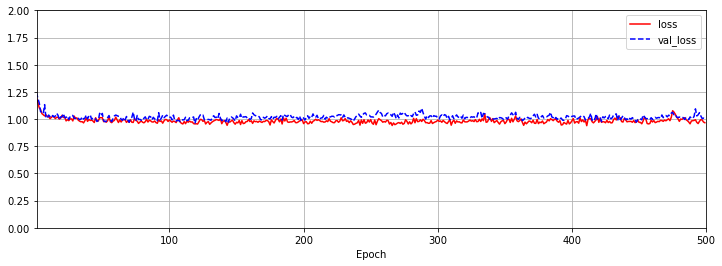

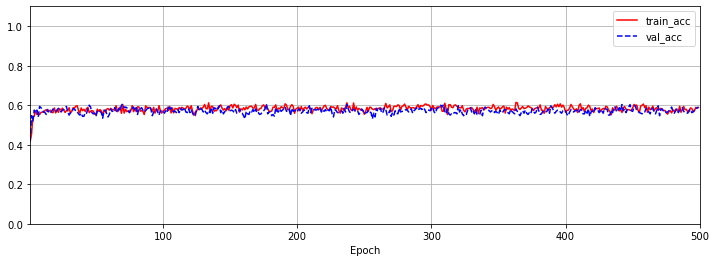

In [22]:
# loss
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], 'r-', label='loss')
plt.plot(history.history['val_loss'], 'b--', label='val_loss')
plt.xlabel('Epoch')
plt.xlim(1,training_epochs)
plt.ylim(0,2)
plt.legend()
plt.grid()
plt.show()

# accuracy
plt.figure(figsize=(12,4))
plt.plot(history.history['accuracy'],'r-', label='train_acc')
plt.plot(history.history['val_accuracy'],'b--', label='val_acc')
plt.xlabel('Epoch')
plt.xlim(1,training_epochs)
plt.ylim(0,1.1)
plt.legend()
plt.grid()
plt.show()